# Nonlinear analysis -Assignment 2

26.09.2023 - Jérémie Engler and Laure Toullier

## Exercice 1

### Imports

In [69]:
import numpy as np
import matplotlib.pyplot as plt

Definitions

In [70]:
# Element connectivity
nelements = 2 
nnodes = 3

# Written input:
connectivity = np.array([[1, 2], [3, 2]])
nodes_P = np.array([2])

# Unit stiffness matrix of bar in local coordinate system
K_unit = np.array([[1, 0, -1, 0], 
                   [0, 0,  0, 0], 
                   [-1, 0, 1, 0], 
                   [0, 0, 0, 0]])

# Input data and element stiffness matrices
E = [200e3,200e3]  # N/mm^2 Young modulus of the elements
A = [15e3,2e3] #mm^2 Cross-sectional area of the elements
a = 3000 #mm Half lenght of the truss
b = 4000 #mm Height of the truss
P = 10000e3 #7862e3 #N Load
phiP = 60 #° Angle of load
theta = [53.13, -53.13] #° Angle of elements, at first node of the element
Pglob = np.array([P*np.cos(np.radians(phiP)), P*np.sin(np.radians(phiP))]) #N P force in global coordinates (x,y)
alpha = 0.02
sigmay = 500 #Mpa

Initial stiffness and event to event analysis

P before first iteration:[5000000.         8660254.03784439]
alphas = [1, 1]
Loads from previous iterations: [0, 0]
Element 0, lambda = 0.7829363496579835
[0]
lambdas = [0.7829363496579835]
Pcp = [array([3914681.74828992, 6780427.6835007 ])]
1
Applied force at iteration 0, with corrected load = [3914681.74828992 6780427.6835007 ]
Displacement at iteration 0, with corrected load = [ 0.25472837 15.43393673]
axialFprev = [7500000.0, -975545.9600340928]
Incremental axial load in element 1: 7500000 N

Incremental axial load in element 2: -975546 N

Left support:
Node 1, incremental horizontal displacement: 0.0 mm
Node 1, incremental vertical displacement: 0.0 mm

Node 1, incremental horizontal force: -4500011 N
Node 1, incremental vertical force: -5999992 N


Node 2, incremental horizontal displacement: 0.25 mm
Node 2, incremental vertical displacement: 15.43 mm

Node 2, incremental horizontal force: 3914682 N
Node 2, incremental vertical force: 6780428 N


Right support:
Node 3, incrementa

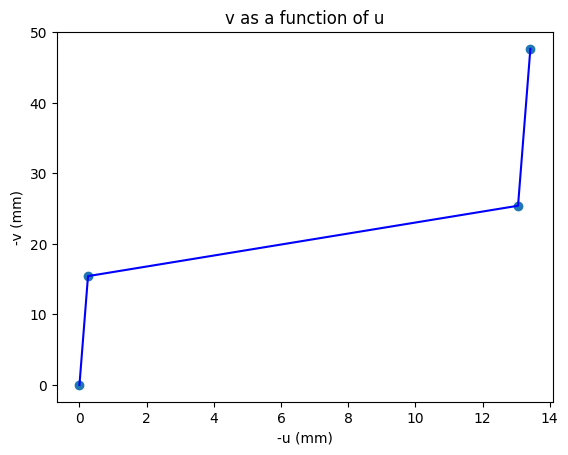

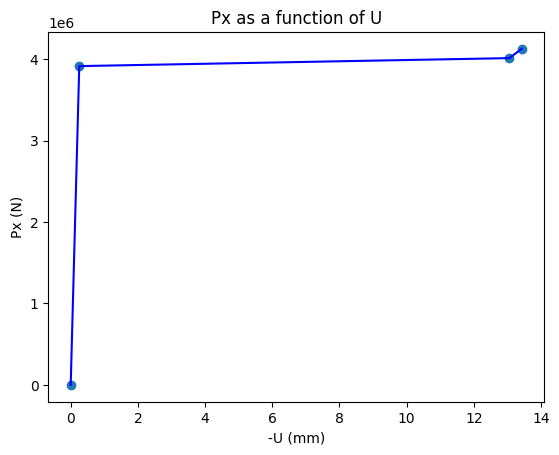

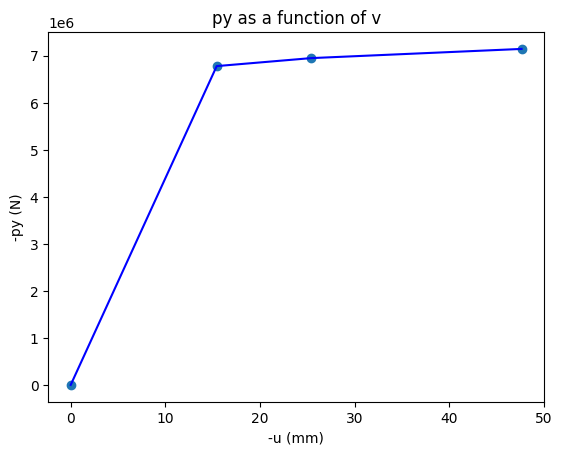

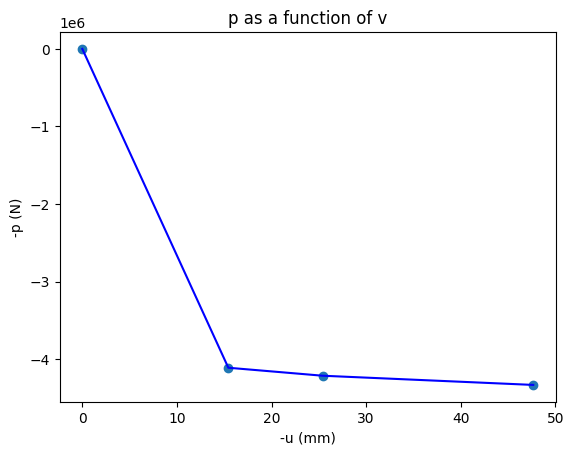

In [95]:

T = np.zeros((nelements,4,4))
L = []
k = []
k_glob = np.zeros((nelements,4,4))
Fy = []

for i in range(nelements):
    c = np.cos(np.radians(theta[i]))
    s = np.sin(np.radians(theta[i]))
    Li = abs(a/c)
    if theta[i] == -90:
        Li = b
    Ai = A[i]
    Ei = E[i]
    T[i] = np.array([[c, s, 0, 0], 
              [-s, c, 0, 0], 
              [0, 0, c, s], 
              [0, 0, -s, c]])
    L.append(Li)
    Fyi = sigmay * A[i]
    Fy.append(Fyi)

for i in range(nelements):
    ki = E[i] * A[i] / L[i]
    k.append(ki)
    k_glob[i] = ki * T[i].T @ K_unit @ T[i]

plastifiedelem = [] #Track which elements are plastified
Pcp = []
lambdatemp = []
alphaelem = [1,1]
Ucp = np.zeros((nelements,2,1))
Pglobit = Pglob
print(f"P before first iteration:{Pglob}")

u = [0]
v = [0]
px = [0]
py = [0]
p = [0]

while len(plastifiedelem) < nelements: 
    print(f"alphas = {alphaelem}")
    lambdait = 1

    #Calculate P from last iterations
    Plastit = [0,0]
    for i in range(len(Pcp)):
        Plastit += Pcp[i] 
    print(f"Loads from previous iterations: {Plastit}")
    
    # Assemble global stiffness matrix
    NDoF = 2*nnodes
    K_global = np.zeros((NDoF,NDoF))
    K_globals = np.zeros((nelements,NDoF, NDoF))


    # Assemble elements
    for i in range (nelements):
        connectelem = connectivity[i] #nodes connected to the element
        indexs = 2*connectelem
        i11 = indexs[0]-2
        i12 = indexs[0]
        i21 = indexs[1]-2
        i22 = indexs[1]

        Ki_global = np.zeros((NDoF, NDoF))
        ki_global = alphaelem[i]*k_glob[i]
        Ki_global[i11:i12, i11:i12] = ki_global[0:2, 0:2]
        Ki_global[i21:i22, i11:i12] = ki_global[2:4, 0:2]
        Ki_global[i11:i12, i21:i22] = ki_global[0:2, 2:4]
        Ki_global[i21:i22, i21:i22] = ki_global[2:4, 2:4]
        K_global = K_global + Ki_global
        K_globals[i] = Ki_global
    
    #System equilibrium with incremental load

    # Calculate displacements at nodes with forces applied
    numnodesP = len(nodes_P)
    F_red = Pglob
    # print(f"Applied force at iteration {len(plastifiedelem)} = {F_red}")
    indexssup = 2*nodes_P - 1
    indexsinf = indexssup - 1
    mask = []
    for i in range(numnodesP):
        mask.append(indexsinf[i])
        mask.append(indexssup[i])
    K_red = K_global[mask,:]
    K_red = K_red[:,mask]

    u_red = np.linalg.inv(K_red) @ F_red
    # print(f"Displacement at iteration {len(plastifiedelem)} = {u_red}")

    # Calculate reaction forces at other nodes
    u_vec = np.zeros((2*nnodes))

    for i in range(numnodesP):
        u_vec[indexsinf[i]] = u_red[2*i]
        u_vec[indexssup[i]] = u_red[2*i+1]

    F = K_global @ u_vec


    # Calculate axial forces
    axialF = []
    for i in range(nelements):
        F_elei = K_globals[i] @ u_vec
        index_red = 2*connectivity[i]
        F_elei_red = F_elei[[index_red[0]-2, index_red[0]-1, index_red[1]-2, index_red[1]-1]]
        F_elei_local = T[i] @ F_elei_red
        Fi = F_elei_local[2]
        axialF.append(Fi)

    pelemindex = -1
    for i in range(nelements):
        if abs(axialF[i]) > Fy[i] and abs(Fy[i]/axialF[i]) < lambdait and Fy[i] != 0:
            # plastifiedelem.append(i)
            if len(plastifiedelem) != 0:
                lambdait = abs((Fy[i]-abs(axialFprev[i]))/axialF[i])
            else:
                lambdait = abs((Fy[i])/axialF[i])
            print(f"Element {i}, lambda = {lambdait}")
            pelemindex = i
            Fy[i] = 0
    
    if pelemindex != -1:
        plastifiedelem.append(pelemindex)
        lambdatemp.append(lambdait)
        alphaelem[pelemindex] = alpha

    print(plastifiedelem)
    print(f"lambdas = {lambdatemp}")

    Pcpi = lambdait * Pglobit
    Pcp.append(Pcpi)

    print(f"Pcp = {Pcp}")

    print(len(plastifiedelem))


    #System equilibrium with plastification load for iteration

    Plastit = [0,0]
    if len(Pcp) > 0:
        for i in range(len(Pcp)):
            Plastit = Pcp[-1] 

    # Calculate displacements at nodes with forces applied
    numnodesP = len(nodes_P)
    F_red = Plastit
    print(f"Applied force at iteration {len(plastifiedelem)-1}, with corrected load = {Plastit}")
    indexssup = 2*nodes_P - 1
    indexsinf = indexssup - 1
    mask = []
    for i in range(numnodesP):
        mask.append(indexsinf[i])
        mask.append(indexssup[i])
    K_red = K_global[mask,:]
    K_red = K_red[:,mask]

    u_red = np.linalg.inv(K_red) @ F_red
    print(f"Displacement at iteration {len(plastifiedelem)-1}, with corrected load = {u_red}")

    # Calculate reaction forces at other nodes
    u_vec = np.zeros((2*nnodes))

    for i in range(numnodesP):
        u_vec[indexsinf[i]] = u_red[2*i]
        u_vec[indexssup[i]] = u_red[2*i+1]

    F = K_global @ u_vec


    # Calculate axial forces
    axialF = []
    for i in range(nelements):
        F_elei = K_globals[i] @ u_vec
        index_red = 2*connectivity[i]
        F_elei_red = F_elei[[index_red[0]-2, index_red[0]-1, index_red[1]-2, index_red[1]-1]]
        F_elei_local = T[i] @ F_elei_red
        Fi = F_elei_local[2]
        axialF.append(Fi)

    axialFprev = axialF

    print(f"axialFprev = {axialFprev}")

    for i in range(nelements):
        print(f"Incremental axial load in element {i+1}: {round(axialF[i])} N")
        print()

    for i in range(nnodes):
        if i == 0:
            print("Left support:")
        if i == 2:
            print("Right support:")
        print(f"Node {i+1}, incremental horizontal displacement: {round(u_vec[2*i],2)} mm")
        print(f"Node {i+1}, incremental vertical displacement: {round(u_vec[2*i+1],2)} mm")
        print()
        print(f"Node {i+1}, incremental horizontal force: {round(F[2*i])} N")
        print(f"Node {i+1}, incremental vertical force: {round(F[2*i+1])} N")
        print()
        print()

    for i in nodes_P:
        j = i-1
        u.append(u_vec[2*j]+u[-1])
        v.append(u_vec[2*j+1]+v[-1])
        px.append(F[2*j]+px[-1])
        py.append(F[2*j+1]+py[-1])
        p.append(F[2*j]/np.cos(phiP)+p[-1])

    print()

# Final slope

final_load = Pcp[-1]*1.15

 # Assemble global stiffness matrix
NDoF = 2*nnodes
K_global = np.zeros((NDoF,NDoF))
K_globals = np.zeros((nelements,NDoF, NDoF))


# Assemble elements
for i in range (nelements):
    connectelem = connectivity[i] #nodes connected to the element
    indexs = 2*connectelem
    i11 = indexs[0]-2
    i12 = indexs[0]
    i21 = indexs[1]-2
    i22 = indexs[1]

    Ki_global = np.zeros((NDoF, NDoF))
    ki_global = alphaelem[i]*k_glob[i]
    Ki_global[i11:i12, i11:i12] = ki_global[0:2, 0:2]
    Ki_global[i21:i22, i11:i12] = ki_global[2:4, 0:2]
    Ki_global[i11:i12, i21:i22] = ki_global[0:2, 2:4]
    Ki_global[i21:i22, i21:i22] = ki_global[2:4, 2:4]
    K_global = K_global + Ki_global
    K_globals[i] = Ki_global

#System equilibrium with incremental load

# Calculate displacements at nodes with forces applied
numnodesP = len(nodes_P)
F_red = final_load
# print(f"Applied force at iteration {len(plastifiedelem)} = {F_red}")
indexssup = 2*nodes_P - 1
indexsinf = indexssup - 1
mask = []
for i in range(numnodesP):
    mask.append(indexsinf[i])
    mask.append(indexssup[i])
K_red = K_global[mask,:]
K_red = K_red[:,mask]

u_red = np.linalg.inv(K_red) @ F_red
# print(f"Displacement at iteration {len(plastifiedelem)} = {u_red}")

# Calculate reaction forces at other nodes
u_vec = np.zeros((2*nnodes))

for i in range(numnodesP):
    u_vec[indexsinf[i]] = u_red[2*i]
    u_vec[indexssup[i]] = u_red[2*i+1]

F = K_global @ u_vec


for i in nodes_P:
    j = i-1
    u.append(u_vec[2*j]+u[-1])
    v.append(u_vec[2*j+1]+v[-1])
    px.append(F[2*j]+px[-1])
    py.append(F[2*j+1]+py[-1])
    p.append(F[2*j]/np.cos(phiP)+p[-1])


#Plot 1
# plt.subplot(2,2,1)


plt.plot(u,v,'o')
plt.plot(u,v,'b')

plt.title('v as a function of u')
plt.xlabel("-u (mm)")
plt.ylabel("-v (mm)")

plt.show()
    

#Plot 2

# plt.subplot(2,2,2)
plt.plot(u,px,'o')
plt.plot(u,px,'b')

plt.title('Px as a function of U')
plt.xlabel("-U (mm)")
plt.ylabel("Px (N)")

plt.show()
    

#Plot 3

# plt.subplot(2,2,3)
plt.plot(v,py,'o')
plt.plot(v,py,'b')

plt.title('py as a function of v')
plt.xlabel("-u (mm)")
plt.ylabel("-py (N)")

plt.show()

#Plot 4

# plt.subplot(2,2,3)
plt.plot(v,p,'o')
plt.plot(v,p,'b')

plt.title('p as a function of v')
plt.xlabel("-u (mm)")
plt.ylabel("-p (N)")
  

plt.show()
    
    

System equilibrium

Plastifaction

In [23]:
print('All element plastified, determination of final stiffness')
print(f"alphas = {alphaelem}")
lambdait = 1

#Calculate P from last iterations
Plastit = [0,0]
for i in range(len(Pcp)):
    Plastit += Pcp[i] 
print(f"Loads from previous iterations: {Plastit}")

# Assemble global stiffness matrix
NDoF = 2*nnodes
K_global = np.zeros((NDoF,NDoF))
K_globals = np.zeros((nelements,NDoF, NDoF))


# Assemble elements
for i in range (nelements):
    connectelem = connectivity[i] #nodes connected to the element
    indexs = 2*connectelem
    i11 = indexs[0]-2
    i12 = indexs[0]
    i21 = indexs[1]-2
    i22 = indexs[1]

    Ki_global = np.zeros((NDoF, NDoF))
    ki_global = alphaelem[i]*k_glob[i]
    Ki_global[i11:i12, i11:i12] = ki_global[0:2, 0:2]
    Ki_global[i21:i22, i11:i12] = ki_global[2:4, 0:2]
    Ki_global[i11:i12, i21:i22] = ki_global[0:2, 2:4]
    Ki_global[i21:i22, i21:i22] = ki_global[2:4, 2:4]
    K_global = K_global + Ki_global
    K_globals[i] = Ki_global

#System equilibrium

# Calculate displacements at nodes with forces applied
numnodesP = len(nodes_P)
F_red = Plastit + Pglob
print(f"Applied force at iteration {len(plastifiedelem)} = {F_red}")
indexssup = 2*nodes_P - 1
indexsinf = indexssup - 1
mask = []
for i in range(numnodesP):
    mask.append(indexsinf[i])
    mask.append(indexssup[i])
K_red = K_global[mask,:]
K_red = K_red[:,mask]

u_red = np.linalg.inv(K_red) @ F_red

# Calculate reaction forces at other nodes
u_vec = np.zeros((2*nnodes))

for i in range(numnodesP):
    u_vec[indexsinf[i]] = u_red[2*i]
    u_vec[indexssup[i]] = u_red[2*i+1]

F = K_global @ u_vec


# Calculate axial forces
axialF = []
for i in range(nelements):
    F_elei = K_globals[i] @ u_vec
    index_red = 2*connectivity[i]
    F_elei_red = F_elei[[index_red[0]-2, index_red[0]-1, index_red[1]-2, index_red[1]-1]]
    F_elei_local = T[i] @ F_elei_red
    Fi = F_elei_local[2]
    axialF.append(Fi)


0
-4518768.899191153
1
[0]
[0.9958488293792715]
